In [2]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="darkgrid")
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# Считываем данные из файла

In [16]:
df = pd.read_csv(r'C:\Users\Алексей\Desktop\Тестовое задание\creditcard.csv')

# Проверяем наличие взаимозависимых факторов.
Из каждой пары таких факторов можно оставить только один, а второй можно удалить для дальнейщего анализа, так как он определяется первым фактором и не несет полезной информации.
Вычислим коэффициент корелляции Пирсона для каждой пары факторов.

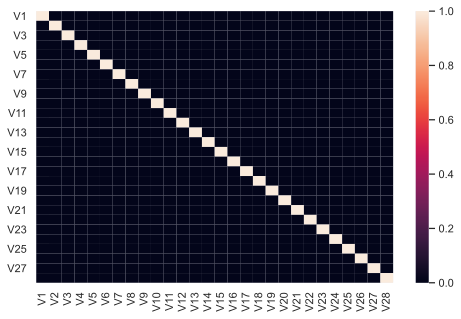

In [3]:
df_factors = df[[x for x in df.columns if 'V' in x]]
sns.heatmap(df_factors.corr());

Взаимозависимых факторов нет, все факторы можно оставить для дальнейщего анализа

# Проверим зависомость фродовой активности от времени суток
Сгруппируем данные по времени с шагом равным 1 часу и вычислим для каждой группы отношение фродовых транзакций к общему количеству транзакций в группе в %

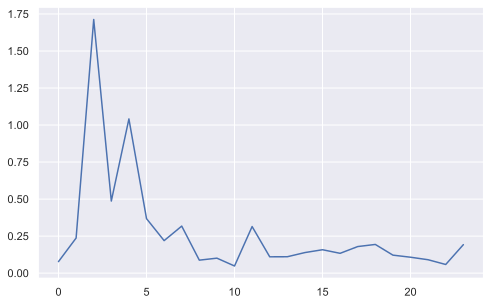

In [7]:
def sec_to_h(s):
    return s//60//60%24
df_time_class = df[['Class']]
df_time_class['Time'] = df['Time'].map(sec_to_h)
cross_time_class = pd.crosstab(df_time_class['Time'], df_time_class['Class'])
cross_time_class['Fraud_perc'] = cross_time_class[1]/(cross_time_class[0] + cross_time_class[1])*100
plt.plot( cross_time_class.index, cross_time_class.Fraud_perc);

График показывает, что наибольшая фродовая активность приходится на период с 02:00 до 6:00 каждых суток (если принять время первой транзакции равным 00:00). Но, возможно, какой-либо фактор коррелрует со времменем и именно он определяет такую фродовую активность в этот период.

# Посмотрим на распределения всех интересующих нас количественных признаков - факторов V1-V12

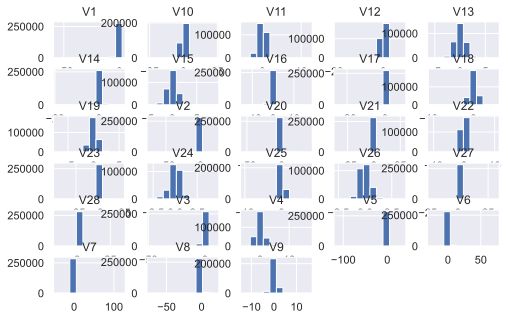

In [38]:
df_factors.hist();

### Удалим выбросы и снова построим гистограммы распределения

In [8]:
def cut_ej(s):
    return s[(s > s.quantile(0.01)) &
             (s < s.quantile(0.99))]
df_factors_distr = pd.DataFrame()
for i in df_factors.iteritems():
    df_factors_distr[i[0]] = cut_ej(i[1])

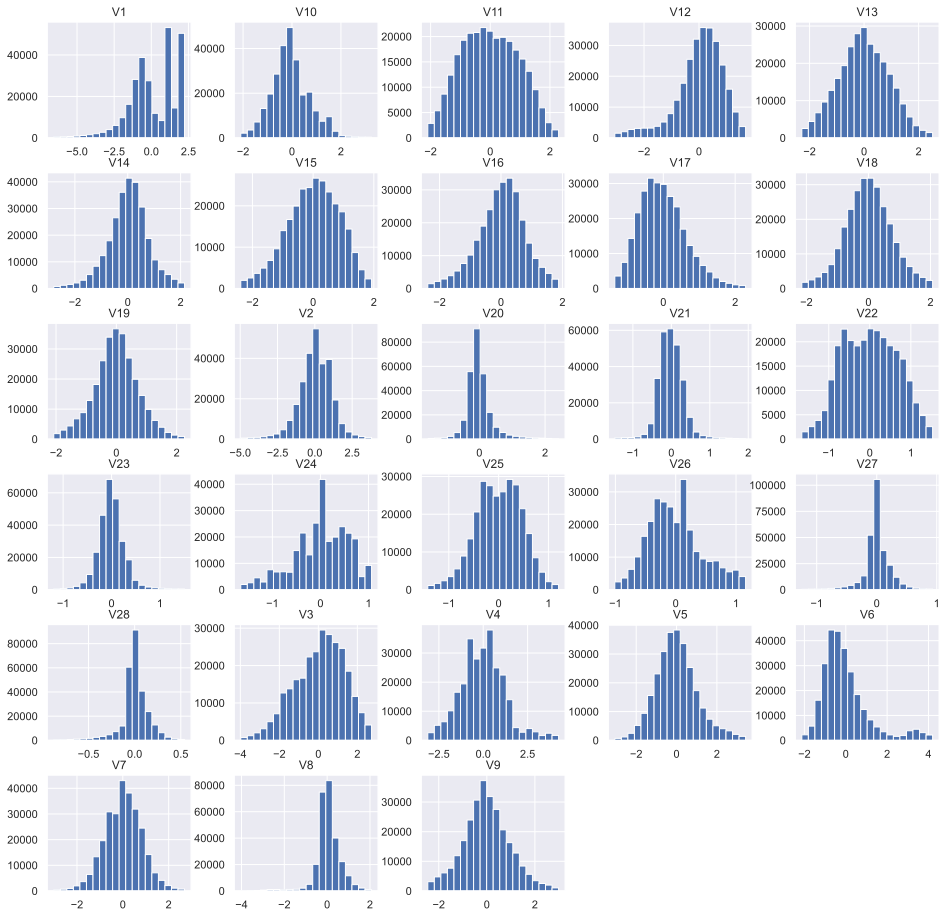

In [69]:
df_factors_distr.hist(figsize=(16, 16), bins=20);

Большенство факторов имеют распределение, близкое к нормальному, за исключением фактора V1.

# Посмотрим, как факторы связаны с фродовыми транзакциями
Построим boxplot-ы, описывающее статистики распределения количественных признаков в двух группах: фродовых и нефродовых транзакций

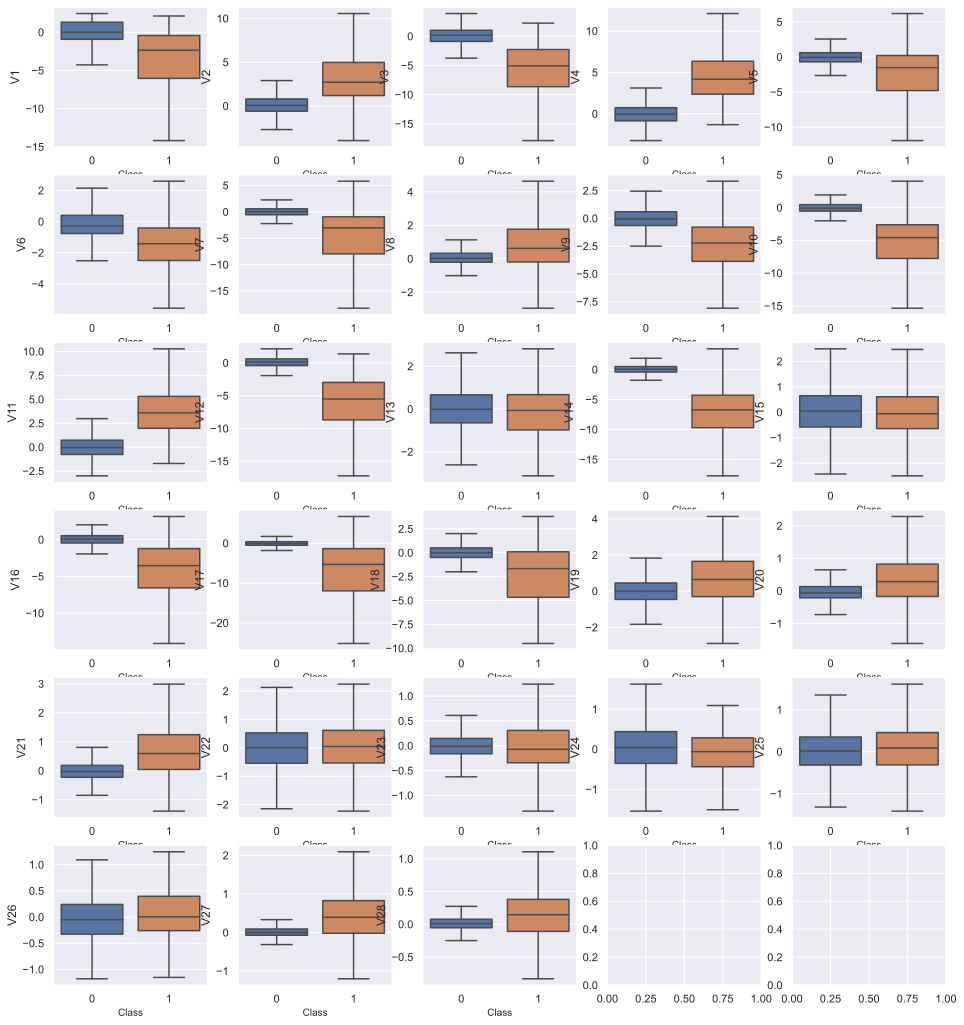

In [86]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 18))
for n, v in enumerate(df_factors.columns):
    sns.boxplot(x='Class', y=v, data=df, showfliers=False, orient='v', ax=axes[n//5, n%5]);
    axes[n//5, n%5].set_xlabel('Class', size=10)

#### Наибольшее влияние оказывают следующие факторы:

In [9]:
significant_factors = ['V2', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

#### Распреления некоторых значимых факторов на boxplot-х очень похожи. Проверим крреляцию значимых факторов внутри группы 1 (фродовые транзакции):

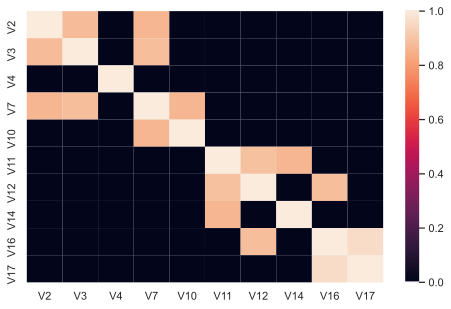

In [10]:
df_cor_sf = df[[x for x in df.columns if x in significant_factors]][df['Class'] == 1].corr()

# Выберем значения корреляции больше 0.8 
hm_cor_sf = df_cor_sf.applymap(lambda x: abs(x) if abs(x) > 0.85
                   or x == 1
                   else 0)
sns.heatmap(hm_cor_sf);

#### Удалим по одному фактору из каждой пары взаимозависимых факторов
Снова проверим корреляцию оставшихся факторов между друг другом

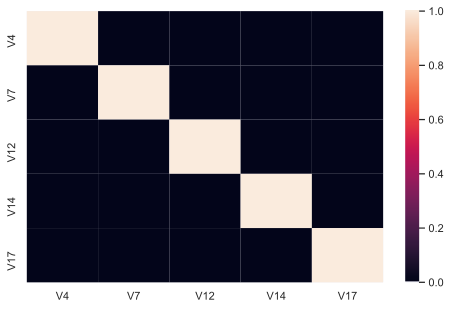

In [11]:
drop_V = ['V2', 'V3', 'V11', 'V16', 'V10']
hm_cor_sf_dr = hm_cor_sf.drop(drop_V)
hm_cor_sf_dr = hm_cor_sf_dr.drop(drop_V, axis=1)
sns.heatmap(hm_cor_sf_dr);

Корреляция всех оставшихся факторов менее 0.85. Для классификации будем использовать только их.

In [12]:
significant_factors = [i for i in significant_factors if i not in drop_V]

## Модель классификации
#### Будем использовать две модели - дерево решений и метод случайных соседей
Обучим модели. Для этого разобъем датасет на обучающую и тестовую выборки с соотношением 70% и 30%. Исходные параметры модели выбираем наугад.

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

X_train, X_holdout, y_train, y_holdout = train_test_split(df.iloc[:, df.columns.isin(significant_factors)],
                                                          df['Class'], test_size=0.3, random_state=17)

tree = DecisionTreeClassifier(max_depth=3, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train);

##### Проверим качество наших моделей по критерию доли правильных ответов

In [67]:
from sklearn.metrics import accuracy_score
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
print('Tree', accuracy_score(y_holdout, tree_pred))
print('Knn ', accuracy_score(y_holdout, knn_pred))

Tree 0.9992977774656788
Knn  0.9994733330992591


С данными параметрами метод ближайщих соседей справилься с задачей лучше чем дерево. Но так как исходная выборка является несбалансированной (доля фродовых транзакций около 0.2%), то правильей будет оценивать ответы модели по каждой группе отдельно.

In [70]:
from sklearn.metrics import recall_score, confusion_matrix
print('Tree recall: ', recall_score(y_holdout, tree_pred))
print(confusion_matrix(y_holdout, tree_pred))
print('Knn recall: ', recall_score(y_holdout, knn_pred))
print(confusion_matrix(y_holdout, knn_pred))

Tree recall:  0.7054794520547946
[[85280    17]
 [   43   103]]
Knn recall:  0.7534246575342466
[[85288     9]
 [   36   110]]


Метод ближайших соседей сработал лучше и предсказал 75% фродовых транзакций (110 из 146), что, на мой взгляд, неплохо для модели, построенной наугад.

## Настройка параметров модели
#### Для настройки параметров будем обучать модель на 5-кратной кросс-валидации. В качесиве метрики для кросс-валидации используем отзыв.
##### Настроим парамаетры для дерева решений:

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
tree_params = {'max_depth': range(6, 8), 'max_features': range(5, 20)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, scoring=make_scorer(recall_score))
tree_grid.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.7s finished


Проверяем качество модели:

In [65]:
tree_pred = tree_grid.predict(X_holdout)
print('Best params:', tree_grid.best_params_)
print('Tree recall hold: ', recall_score(y_holdout, tree_pred))
print('Tree recall cross: ', tree_grid.best_score_)
print(confusion_matrix(y_holdout, tree_pred))

Best params: {'max_depth': 7, 'max_features': 5}
Tree recall hold:  0.773972602739726
Tree recall cross:  0.7397101449275362
[[85283    14]
 [   33   113]]


77% выявленых фродовых транзакций на тестовой выборке и 74% на кросс-валидации, что немного лучше предыдущего значения 70%.

##### Настроим парамаетры для метода ближайших соседей:

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True, scoring=make_scorer(recall_score))

knn_grid.fit(X_train, y_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


Проверяем качество модели:

In [96]:
knn_pred = knn_grid.predict(X_holdout)
print('Best params:', knn_grid.best_params_)
print('knn recall hold: ', recall_score(y_holdout, knn_pred))
print('knn recall cross: ', knn_grid.best_score_)
print(confusion_matrix(y_holdout, knn_pred))

Best params: {'knn__n_neighbors': 9}
knn recall hold:  0.7876712328767124
knn recall cross:  0.7773084886128365
[[85288     9]
 [   31   115]]


79% выявленых фродовых транзакций на тестовой выборке и 78% на кросс-валидации при 5 соседях.

#### Обучение модели случайного леса на кросс-валидации

In [4]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
forest_params = {'max_depth': range(1,10), 'max_features': range(4,20)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1,
                           verbose=True, scoring=make_scorer(recall_score))
forest_grid.fit(X_train, y_train)

Проверяем качество модели:

In [95]:
forest_pred = forest_grid.predict(X_holdout)
print('Best params:', forest_grid.best_params_)
print('Forest recall hold: ', recall_score(y_holdout, forest_pred))
print('Forest recall cross: ', forest_grid.best_score_)
print(confusion_matrix(y_holdout, forest_pred))

Best params: {'max_depth': 9, 'max_features': 4}
Tree recall hold:  0.7876712328767124
Tree recall cross:  0.7599171842650103
[[85288     9]
 [   31   115]]


79% выявленых фродовых транзакций на тестовой выборке и 76% на кросс-валидации, что примерно равно результатам метода ближайших соседей.

## Обучение модели на всех данных
##### Предыдущие модели мы обучали только с использованием только тех факторов, которые выбрали как самые значимые. Попробуем обучить модель, используя все факторы.
В процессе работы я сфокусировался на факторах V1-V28 и забыл про сумму транзакции Amount. Добавим фактор суммы в обучение.

In [157]:
# Подготовим данные для обучения
df1 = df
# Время выразим в часах от 0 до 23
df1['Time'] = df_time_class['Time']

#### Выровняем соотношение классов
Мы имеем очень большое количество экземпляров 0-го класса (не фрод.). На boxplot-ах, котороые мы строили ранее, видно, что стандартное отклоненеие факторов в 0-м классе намного меньше чем в 1-м. Поэтому предполагаю, что удалив большую часть экземпляров 0-го класса мы не потеряем много информации.

In [181]:
# Выбираем все экземпляры первого класса и такое же количество экземпляров 0-го класса
df1_1 = df[df['Class'] == 1]
df1_0 = df[df['Class'] == 0]
df1 = pd.concat([df1_1, df1_0.sample(n=len(df1_1))])
# Поверяем общее количество экземпляров
len(df1)

984

#### Обучим модель ближайших соседей

In [189]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df1.iloc[:, :-1],
                                                          df1['Class'], test_size=0.3, random_state=17)
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(3, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True, scoring=make_scorer(recall_score))

knn_grid.fit(X_train, y_train);

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.5s finished


In [190]:
knn_pred = knn_grid.predict(X_holdout)
print('Best params:', knn_grid.best_params_)
print('knn recall hold: ', recall_score(y_holdout, knn_pred))
print('knn recall cross: ', knn_grid.best_score_)
print(confusion_matrix(y_holdout, knn_pred))

Best params: {'knn__n_neighbors': 3}
knn recall hold:  0.8633093525179856
knn recall cross:  0.8808853118712274
[[151   6]
 [ 19 120]]


 86% на тестовой вборке и 88% на кросс-валидации. Это лучше, чем 79% и 78% на предыдущией выборке.

#### Обучим случайный лес на этих же данных

In [194]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
forest_params = {'max_depth': range(1,10), 'max_features': range(4,20)}

forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1,
                           verbose=True, scoring=make_scorer(recall_score))
forest_grid.fit(X_train, y_train);

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.5min finished


Проверяем качество модели:

In [193]:
forest_pred = forest_grid.predict(X_holdout)
print('Best params:', forest_grid.best_params_)
print('Forest recall hold: ', recall_score(y_holdout, forest_pred))
print('Forest recall cross: ', forest_grid.best_score_)
print(confusion_matrix(y_holdout, forest_pred))

Best params: {'max_depth': 9, 'max_features': 16}
Forest recall hold:  0.9424460431654677
Forest recall cross:  0.9148893360160967
[[151   6]
 [  8 131]]


94% на тестовой и 91% на кросс-валидации. Пока это лучшуй результат, который мне удалось получить. Но при этом ухудшился результат по доле блокировки нефродовых транзакций (6 из 157, что соответствует 4%. На предыдущих данных, без удаления экземпляров, этот показатель стремился к 0).

#### Выровняем соотношение классов в большую сторону

In [226]:
# Выбираем все экземпляры 0-го класса и такое же количество экземпляров 1-го класса (создаем копии экземпляров 1-го класса)
df1_1 = df[df['Class'] == 1]
df1_0 = df[df['Class'] == 0]

d = df1_1
while len(df1_0) >= len(df1_1): 
    df1_1 = pd.concat([df1_1, d])

df1 = pd.concat([df1_1, df1_0])

# Поверяем общее количество экземпляров по каждомму классу
len(df1_1), len(df1_0)

(284376, 284315)

#### Обучим случайный лес
Используем параметры, найденные на предыдущем шаге, так как модель с каросс-валидацией на таком объеме данных будет учиться слишком долго

In [229]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df1.iloc[:, :-1],
                                                          df1['Class'], test_size=0.3, random_state=17)

forest_grid = RandomForestClassifier(max_depth=9, max_features=16, n_estimators=100, n_jobs=-1, random_state=17)

forest_grid.fit(X_train, y_train);

Проверяем качество модели:

In [253]:
forest_pred = forest_grid.predict(X_holdout)
print('Forest recall class 1: ', recall_score(y_holdout, forest_pred, labels=[1], average=None))
print('Forest recall class 0: ', recall_score(y_holdout, forest_pred, labels=[0], average=None))
print(confusion_matrix(y_holdout, forest_pred))

Forest recall class 1:  [0.99197627]
Forest recall class 0:  [0.99898808]
[[84901    86]
 [  687 84934]]


##### 99% на тестовой выборке! Отзыв для 0-го класса стремится к 100%!
Как оказалось, задача решается с помощью трех последних ячеек или двух десятков строк кода!

Однако, все не так просто. Я допустил ошибку в том, по сути предоставил модели одни и те же экземпляры 1-го класса в тестовой и обучающей выборках и она их просто выучила. После клонирования экземпляров первого класса одинаковых экземпляров стало настолько много (каждого около 500шт), что каждый уникальный экземпляр попал и в обучающую и в тестовую выборки.

#### Выровняем соотношение классов в большую сторону, разделив экземпляры первого класса для обучающей и тестовой выборки.

In [36]:
# Разделим данные на классы
df1_1 = df[df['Class'] == 1]
df1_0 = df[df['Class'] == 0]

# Каждый класс разделим на обучающую (70%) и тестовую (30%) выборки
df_1_holdout = df1_1.sample(frac=0.3)
df_0_holdout = df1_0.sample(frac=0.3)
df_1_train = df1_1[~df1_1.index.isin(df_1_holdout.index)]
df_0_train = df1_0[~df1_0.index.isin(df_0_holdout.index)]

# Создадим копии экземпляров первого класса так, чтобы количество экземпляров обоих классов было примерно равным
dh = df_1_holdout
while len(df_0_holdout) >= len(df_1_holdout): 
    df_1_holdout = pd.concat([df_1_holdout, dh])
    
dt = df_1_train
while len(df_0_train) >= len(df_1_train): 
    df_1_train = pd.concat([df_1_train, dt])

# Объеденим тестовые и обучающие выборки по классам и перемешаем строки
from sklearn.utils import shuffle
df_holdout = shuffle(pd.concat([df_1_holdout, df_0_holdout]))
df_train = shuffle(pd.concat([df_1_train, df_0_train]));

In [41]:
X_train = df_train.iloc[:, :-1]
X_holdout = df_holdout.iloc[:, :-1]
y_train = df_train['Class']
y_holdout = df_holdout['Class']

forest_grid = RandomForestClassifier(max_depth=9, max_features=16, n_estimators=100, n_jobs=-1, random_state=17)

forest_grid.fit(X_train, y_train);

Проверяем качество модели:

In [42]:
from sklearn.metrics import confusion_matrix
forest_pred = forest_grid.predict(X_holdout)
print('Forest recall class 1: ', recall_score(y_holdout, forest_pred, labels=[1], average=None))
print('Forest recall class 0: ', recall_score(y_holdout, forest_pred, labels=[0], average=None))
print(confusion_matrix(y_holdout, forest_pred))

Forest recall class 1:  [0.85135135]
Forest recall class 0:  [0.99932]
[[85236    58]
 [12694 72702]]


##### Отзыв по первому классу 85%. Это даже меньше чем, при обучении на обрезанных данных.

Для улучшения результатов можно подобрать параметры случайного леса на кросс-валидации. Исходя из того, что пропустить фродовую транзакцию хуже, чем заблокировать нефродовую, можно задать больший вес для отзыва по первому классу или использовать только его в качестве метрики во время обучения. 